

![The Close AGN Reference Survey](images/cars.png "The Close AGN Reference Survey")

# A tour of CARS MUSE Data Products
[Dr. Grant Tremblay](http://www.granttremblay.com) | Harvard-Smithsonian Center for Astrophysics | grant.tremblay @ cfa.harvard.edu

[![astropy](http://img.shields.io/badge/powered%20by-AstroPy-orange.svg?style=flat)](http://www.astropy.org/)

### About CARS

The [Close AGN Reference Survey](http://www.cars-survey.org/) has recently completed three dimensional (spatial+spectral) mapping of nearby ($0.01 < z < 0.06$) Type 1 AGN with the [Multi-Unit Spectroscopic Explorer](https://www.eso.org/sci/facilities/develop/instruments/muse.html) (MUSE), a groundbreaking new Integral Field Unit (IFU) spectrograph on the [Very Large Telescope](http://www.eso.org/public/teles-instr/paranal-observatory/vlt/) (VLT). The program has completed observations of 39 Quasar host galaxies from the Bertram *et al.* (2007) Type 1 AGN sample, all of which enjoy a rich and growing suite of multiwavelength archival data, including new CARS observations from *HST*, ALMA, Gemini, the VLT, and SOAR. 

CARS leverages systematic, multiwavelength mapping to shine light into the "black box" that characterizes many aspects of the AGN feedback paradigm, enabling a better understanding of the conditions of star formation in QSO host galaxies, quenching via AGN-driven outflows, and the galaxy-scale (im)balance of AGN feeding vs. feedback. While kinetic and radiative energy from black holes is now routinely invoked to inhibit star formation and overcooling in galaxy evolution models, very little is known about how this energy actually couples to the ambient kpc-scale gaseous environment, and *direct* (rather than circumstantial) evidence for the so-called "quenching" of star formation remains elusive. By leveraging the unique capabilities of MUSE combined with highly multiwavelength ancillary datasets, CARS is designed to make significant progress in this regard. 




### About our MUSE Data Products

I have assembled this tutorial to acquaint those new to CARS with our MUSE data products. Basic familiarity with Python is assumed.  

[MUSE](https://www.eso.org/sci/facilities/develop/instruments/muse.html) is a high-througput,
wide-FOV, image-slicing optical integral field unit (IFU) spectrograph mounted to
UT4's Nasmyth B focus on the [Very Large Telescope](http://www.eso.org/public/teles-instr/paranal-observatory/vlt/) (VLT). In a single pointing, the instrument obtains 900,000 simultaneous spectra covering $4750 < \lambda < 9300$ \AA  over a $1'\times1'$ field of view. The seeing-limited point spread function of the instrument is sampled by $0.2''$ spaxels. Most CARS MUSE data were obtained with seeing better than 1 arcsecond. 

The CARS team has consumed many hours of wall clock and CPU time 
in the creation of high-level and science-ready MUSE data products. This should allow you to go "straight to the science", without having to worry about the more subtle and complicated aspects of MUSE data reduction. We've taken care of that for you! 

Here's what we've done: The raw data are initially reduced using the standard MUSE pipeline,
automating bias subtraction, wavelength and flux calibration, as well as
illumination-, flat-field, and differential atmospheric diffraction corrections.
In addition to the sky subtraction automated by the pipeline, which
uses a model created from a "blank sky" region of the FoV,
we have performed an additional sky subtraction
using a Principal Component Analysis (PCA) code (to be made public by the CARS team at some point soon). We also correct each cube for 
Galactic foreground extinction using an $A_V$ measured from 
the Schlafly *et al.* recalibration of the Schlegel *et al.* *IRAS+COBE* Milky Way Dust map assuming  $R_V=3.1$.

We then create higher level CARS/MUSE data
products by decoupling and modeling the stellar and nebular components of the galaxy
with `PyParadise` (Husemann, Choudhury & Walcher *et al.*, in prep.).
`PyParadise` iteratively performs non-negative linear least-squares fitting of
stellar population synthesis templates to the stellar spectrum of every relevant
spectral pixel ("spaxel")
in the MUSE cube, while independently finding the best-fit line-of-sight
velocity distribution with a  Markov Chain Monte Carlo (MCMC) method.
The best-fit stellar spectrum is then subtracted from each spaxel,
yielding residuals that contain nebular emission lines. These are fit with a
linked chain of Gaussians that share a common radial velocity, velocity dispersion,
and priors on expected emission line ratios (e.g., the line ratios of the [OIII] and [NII] doublets are fixed to 1:3).
Uncertainties on all best-fit stellar and nebular parameters
are then estimated using a Monte-Carlo bootstrap approach wherein
both continuum and emission lines
are re-fit 100 times as the spectrum is
randomly modulated within the error of each spaxel.

At the end, we're left with FITS tables that encode the kinematics of both the stellar and nebular components of the galaxy, alongside a careful accounting of their associated errors. 

In this tutorial, I'll take you on a simple "guided tour" of these data products. My advice is to make sure you understand every single line of Python below. If you don't understand what a line of code is doing, please let me know! You can email me any time at `grant.tremblay {at} cfa.harvard.edu`. 



#### The Python libraries we'll need for this exercise are imported below. 

I *strongly* recommend using the [Anaconda Python Distribution](https://www.anaconda.com/download/#linux), which will provide you everything you need out of the box. Familiarity with [Astropy](http://www.astropy.org) is also recommended.

In [66]:
import os
import sys
import glob

from astropy.io import fits
import astropy.constants as const
import astropy.units as u

import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm

### This is magic for Jupyer Notebooks. 
### Delete if putting into a script!
%matplotlib inline 
#######################################

import imageio 

## CARS Data Products

I've placed our standard MUSE products for a randomly chosen CARS galaxy (as an example) in this directory: 

In [5]:
cars_data_directory = 'data/'
os.listdir(cars_data_directory)

['HE0227-0913.eline_table.fits',
 'HE0227-0913.stellar_table.fits',
 'HE0227-0913.kin_table.fits',
 'HE0227-0913.eline_model.fits',
 'HE0227-0913.QSO_full.fits',
 'HE0227-0913_FOV_SDSSr.fits',
 'HE0227-0913.cont_model.fits',
 'HE0227-0913_FOV_SDSSi.fits',
 'HE0227-0913.binned.fits',
 'HE0227-0913_FOV_SDSSg.fits']

Here's what each of these products are: 


```
*binned.fits = The actual MUSE datacube. 
*eline_table.fits =Emission line kinematics table (from PyParadise fitting). 
*stellar_table.fits = Stellar kinematics table (from PyParadise fitting).
*kin_table.fits = Stellar kinematics taking into account Voronoi bins.
*QSO_full.fits = QSO/Host galaxy deblending model. Remember, these are Type 1 AGN!***
*cont_model.fits = Stellar continuum model subtracted from each spaxel.
*eline_model.fits = Best fit model to the residuals, i.e. the nebular component. 
*FOV*.fits = Collapsed MUSE 'images' meant to mimic imaging in various filters. 
```

\***QSO/Host galaxy debplending has already been done, you don't need to worry about it!

The MUSE target we're using for this example is **HE0227-0913 / Mrk 1044)** ([NED entry](http://ned.ipac.caltech.edu/ui/?q=objsearch&out_equinox=J2000.0&objname=Mrk%201044&hconst=73&omegav=0.73&out_csys=Equatorial&corr_z=1&list_limit=5&of=pre_text&obj_sort=RA%20or%20Longitude&extend=no&img_stamp=YES&omegam=0.27)) at a redshift of $z=0.01645$. 

Let's populate some relevant information that we'll need for this galaxy below. 

In [6]:
z = 0.01645 # The redshift, which I just grabbed from NED. Doesn't need to be too exact for our purposes.  
cz = z * const.c.to('km/s') # The stellar systemic velocity that we'll subtract off of our velocity maps. I always use Astropy Units - read up on them if you're not famililar!

Let's check out the galaxy. 

In [7]:
fov = cars_data_directory + 'HE0227-0913_FOV_SDSSr.fits' # I'm really just using this to grab the dimensions. Nothing clever here. 

In [8]:
hdu = fits.open(fov)
hdr = hdu[1].header
fovdata = hdu[1].data
dim = hdu[1].data.shape
hdu.close()

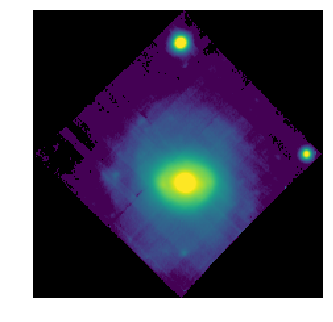

In [9]:
fig = plt.figure()

ax = plt.axes([0,0,1,1])

cmap = cm.viridis
cmap.set_bad('black',1)

plt.axis('off')
frame = plt.imshow(fovdata, origin='lower', norm=LogNorm(), vmin=0.001, vmax=0.1, cmap=cmap, interpolation='None')

### Generate Stellar Kinematics Maps

Unlike emission lines like H$\alpha$, the stellar continuum is *fairly* faint. We've therefore applied Voronoi Binning to increase the S/N of the stellar component. [You can read more about that here](http://www-astro.physics.ox.ac.uk/~mxc/software/#binning). 

Obviously, this seriously degrades the spatial resolution for the stellar compoent. We won't do that for the gas, where we *care* about spatial resolution. We only care about the coarse stellar velocity map, because we can't do better than that anyway!

In [10]:
stars = cars_data_directory + 'HE0227-0913.kin_table.fits' # The Voronoi-binned Stellar Kinematics Tablegas = cars_data_directory + 'HE0227-0913.eline_table.fits' # The UNBINNED Gas kinematics Table

In [11]:
# Read in the stellar table, from which we'll make stellar maps
stellar_hdu = fits.open(stars)
stellar_tab = stellar_hdu[1].data

stellar_columns = stellar_hdu[1].header

In [12]:
# Make arrays for the spatial coordinates
stellar_x_cor = stellar_tab.field('x_cor')
stellar_y_cor = stellar_tab.field('y_cor')

# Populate arrays for the Stellar Velocity
stellar_vel = stellar_tab.field('vel_fit')
stellar_vel_err = stellar_tab.field('vel_fit_err')

# ... and the FWHM! 
stellar_fwhm = stellar_tab.field('disp_fit')
stellar_fwhm_err = stellar_tab.field('disp_fit_err')

Threshold the Stellar data on Signal to Noise

In [13]:
# This just creates a boolean "mask" for the data, showing only S/N > 500 spaxels. 
# We also clip low and high velocity outliers that are near the edge of the FoV. This is bad data.
stellar_select = ((stellar_vel / stellar_vel_err) > 500.0) & (stellar_vel > 4400 ) & (stellar_vel < 5200)

/home/grant/Software/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/grant/Software/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


... don't worry about the RuntimeWarning. 

Make a "dummy" empty map that is the same shape as the 2D FOV

In [19]:
stellar_vel_map = np.full((dim[0], dim[1]), np.nan)

... and now populate this with our masked stellar velocity data

In [20]:
stellar_vel_map[stellar_x_cor[stellar_select], stellar_y_cor[stellar_select]] = stellar_vel[stellar_select]

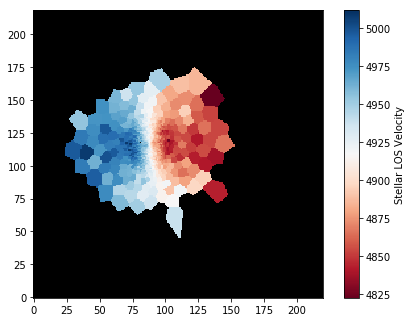

In [21]:
fig = plt.figure()

ax = plt.axes([0,0,1,1])

cmap = cm.RdBu
cmap.set_bad('black',1)

vmin = -500.
vmax = 500.


frame = plt.imshow(stellar_vel_map, origin='lower', cmap=cmap, interpolation='None')
cbar = plt.colorbar()
cbar.set_label(r"Stellar LOS Velocity")

Check out that absolutely beautiful Keplerian rotation of the stars. Lovely. This is a nearly face-on galaxy, but it is just inclined enough to show this rotation pattern. The projection of the velocity field along the line of sight is nevertheless small ($v \sin i$) because the inclination is nearly face-on. 

Note that we haven't subtracted off the "hubble flow", i.e. the systemic velocity of the galaxy. Let's do that now. It'll effectively project the rotation around a "zero point" that we set to be the median of the observed velocity field. This is effectively a direct MUSE measurement of the stellar redshift. 

In [22]:
median_stellar_vel = np.median(stellar_vel[stellar_select])

measured_MUSE_redshift = (median_stellar_vel * (u.km/u.s)) / const.c.to('km/s')

print("The stellar systemic velocity as measured by MUSE is z={}".format(measured_MUSE_redshift.round(5)))

The stellar systemic velocity as measured by MUSE is z=0.01643


Really good! Remember that the reported NED redshift was: 

In [23]:
z

0.01645

Let's subtract the stellar systemic velocity from our velocity map: 

In [24]:
stellar_vel_map[stellar_x_cor[stellar_select], stellar_y_cor[stellar_select]] = stellar_vel[stellar_select] - median_stellar_vel 

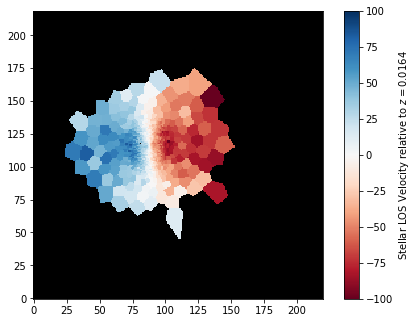

In [25]:
fig = plt.figure()

ax = plt.axes([0,0,1,1])

cmap = cm.RdBu
cmap.set_bad('black',1) # I make the NANs black here because white is included in my colormap, encoding values near zero

frame = plt.imshow(stellar_vel_map, origin='lower', cmap=cmap, vmin=-100, vmax=100, interpolation='None')
cbar = plt.colorbar()
cbar.set_label(r"Stellar LOS Velocity relative to $z=0.0164$")

Remember, you can edit any of these cells to save these figures, etc. I won't get into how to make proper WCS axes for these, but [you can read up on that here](http://www.astropy.org/astropy-tutorials/FITS-images.html). 

I also won't be saving FITS images of these maps, but it's similarly trivial. Use the general example below to save any of the maps made in this tutorial as a FITS image. 

In [26]:
# hdu = fits.PrimaryHDU(stellar_vel_map)
# hdu.header = hdr 
# hdu.writeto('stellar_vel_map.fits',clobber=True,output_verify='fix')

The stellar FWHM map is similarly easy to make follwing the example above, i.e. 

*__REMEMBER__*: $FWHM = 2.35 \sigma$

Be careful when comparing velocity dispersion and FWHM maps!! 

In [27]:
# We're in *such* a high S/N regime that I'm just going to use the same stellar_select 
# boolean mask as above, even though I technically created it based on S/N in the *velocity*
# fit, not with FWHM fit. The Velocity and FWHM maps will therefore have an identical footprint. 
# Really, everything is so high S/N that this is basically not relevant. 

stellar_fwhm_map = np.full((dim[0], dim[1]), np.nan)
stellar_fwhm_map[stellar_x_cor[stellar_select], stellar_y_cor[stellar_select]] = stellar_fwhm[stellar_select]

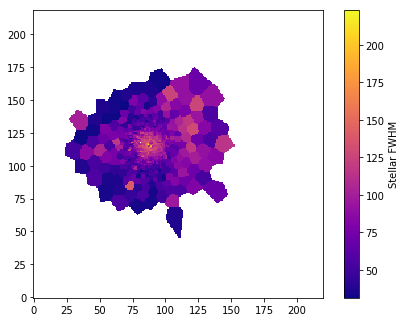

In [28]:
fig = plt.figure()

ax = plt.axes([0,0,1,1])

cmap = cm.plasma
cmap.set_bad('white',1) # Make the NANs white

frame = plt.imshow(stellar_fwhm_map, origin='lower', cmap=cmap, interpolation='None')
cbar = plt.colorbar()
cbar.set_label(r"Stellar FWHM")

You'll notice I'm being super lazy by not making my label sizes large, not adding proper WCS axes, not adding scale bars (in kpc and arcseconds), etc. *Don't be like me*. Always add scalebars. Always make labels readable. Always use perceptually uniform colormaps. Data vizualization is *important*. 

### Make Velocity and Velocity Dispersion maps for the Emission Line Gas

You should hopefully be getting the hang of this now! 

In [29]:
gas = cars_data_directory + 'HE0227-0913.eline_table.fits' # The UNBINNED Gas kinematics Table

In [30]:
# Read in the emission line table, from which we'll make gas maps
eline_hdu = fits.open(gas)
eline_tab = eline_hdu[1].data

eline_columns = eline_hdu[1].header

In [31]:
# You can check out the header by uncommenting the line below
# eline_columns

We get a lot of bright, beautiful emission lines in CARS MUSE data. You can see all those we've mapped in the `eline_tab` header (see the cell above). The brightest will be H$\alpha$ (which `PyParadise` has conveniently decoupled from [N II]!) and [O III]. Let's look at only a few of them, for the purposes of this tutorial. 

In [32]:
eline_x_cor = eline_tab.field('x_cor')
eline_y_cor = eline_tab.field('y_cor')

H$\alpha$ $\lambda$6563

In [33]:
Ha_flux = eline_tab.field('Halpha_flux')
Ha_flux_err = eline_tab.field('Halpha_flux_err')
Ha_vel = eline_tab.field('Halpha_vel')
Ha_vel_err = eline_tab.field('Halpha_vel_err')
Ha_fwhm = eline_tab.field('Halpha_fwhm')
Ha_fwhm_err = eline_tab.field('Halpha_fwhm_err')

H$\beta$ $\lambda$4861

In [34]:
Hb_flux = eline_tab.field('Hbeta_flux')
Hb_flux_err = eline_tab.field('Hbeta_flux_err')
Hb_vel = eline_tab.field('Hbeta_vel')
Hb_vel_err = eline_tab.field('Hbeta_vel_err')
Hb_fwhm = eline_tab.field('Hbeta_fwhm')
Hb_fwhm_err = eline_tab.field('Hbeta_fwhm_err')

[O III] $\lambda$5007

In [35]:
OIII5007_flux = eline_tab.field('OIII5007_flux')
OIII5007_flux_err = eline_tab.field('OIII5007_flux_err')
OIII5007_vel = eline_tab.field('OIII5007_vel')
OIII5007_vel_err = eline_tab.field('OIII5007_vel_err')
OIII5007_fwhm = eline_tab.field('OIII5007_fwhm')
OIII5007_fwhm_err = eline_tab.field('OIII5007_fwhm_err')

Again, lets mask the data based on a S/N threshold. I could (and should) make a separate mask for each line, but I'm lazy. I'll just make one for H$\alpha$ and apply it to all. 

In [36]:
gas_select = (Ha_flux / Ha_flux_err > 3)

In [42]:
Ha_flux_map = np.full((dim[0],dim[1]) ,np.nan)
Ha_flux_map[eline_y_cor[gas_select],eline_x_cor[gas_select]] = Ha_flux[gas_select]

/home/grant/Software/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


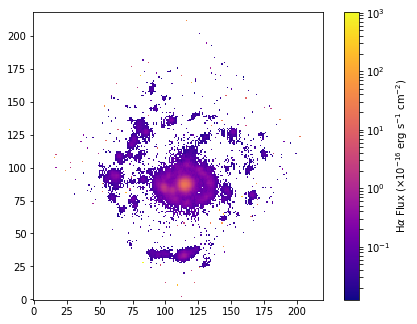

In [38]:
fig = plt.figure()

ax = plt.axes([0,0,1,1])

cmap = cm.plasma
cmap.set_bad('white',1) # Make the NANs white

frame = plt.imshow(Ha_flux_map, origin='lower', cmap=cmap, norm=LogNorm(), interpolation='None')
cbar = plt.colorbar()
cbar.set_label(r"H$\alpha$ Flux ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$)")

In [39]:
median_Ha_vel = np.median(Ha_vel[gas_select])

In [43]:
Ha_vel_map = np.full((dim[0],dim[1]) ,np.nan)
Ha_vel_map[eline_y_cor[gas_select],eline_x_cor[gas_select]] = Ha_vel[gas_select] - median_Ha_vel

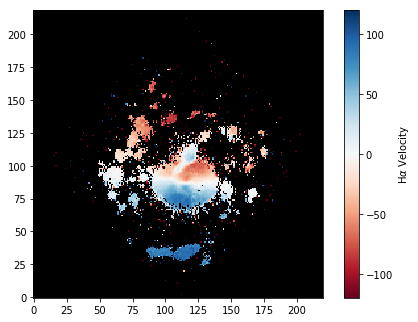

In [44]:
fig = plt.figure()

ax = plt.axes([0,0,1,1])

cmap = cm.RdBu
cmap.set_bad('black',1)

frame = plt.imshow(Ha_vel_map, origin='lower', cmap=cmap, vmin=-120, vmax=120, interpolation='None')
cbar = plt.colorbar()
cbar.set_label(r"H$\alpha$ Velocity")

In [45]:
Ha_fwhm_map = np.full((dim[0],dim[1]), np.nan)
Ha_fwhm_map[eline_y_cor[gas_select],eline_x_cor[gas_select]] = Ha_fwhm[gas_select]

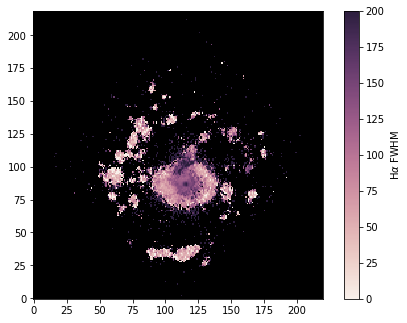

In [46]:
fig = plt.figure()

ax = plt.axes([0,0,1,1])

cmap = sns.cubehelix_palette(20, light=0.95,dark=0.15, as_cmap=True)
cmap.set_bad('black',1)

frame = plt.imshow(Ha_fwhm_map, origin='lower', cmap=cmap, vmin=0, vmax=200, interpolation='None')
cbar = plt.colorbar()
cbar.set_label(r"H$\alpha$ FWHM")

#### An exercise

Hopefully this should be straightforward to you now. Make some flux, velocity, and velocity dispersion maps for some other lines, e.g. [O III]. While you're at it, try to add a proper WCS (Ra / Dec axis) to the figure. 

### Make Line Ratio maps

It's incredibly powerful to have mapped the kinematics of multiple lines. You can make velocity ratio maps to test if the gas is comoving, etc. There are *tons* of applications here. I can't go into all of them.  

One trivial example is a so-called Balmer Decrement map of extinction throughout the galaxy. This is trivial to make from the H$\alpha$ / H$\beta$ flux ratio map. 

I've already made the H$\alpha$ map above, but I'm going to remake it, along with an H$\beta$ map, with a boolean mask based on the S/N of the H$\beta$ line, because it's much fainter than H$\alpha$. 

In [47]:
balmer_select = (Hb_flux / Hb_flux_err > 3)

ha_image = np.full((dim[0],dim[1]) ,np.nan)
hb_image = np.full((dim[0],dim[1]) ,np.nan)

ha_image[eline_y_cor[balmer_select],eline_x_cor[balmer_select]] = Ha_flux[balmer_select]
hb_image[eline_y_cor[balmer_select],eline_x_cor[balmer_select]] = Hb_flux[balmer_select]

We then need only follow the equations on page 7 of [this paper](https://arxiv.org/pdf/1206.1867.pdf)

In [48]:
def make_balmer_map(ha_image, hb_image, hdr, makeplot=True, writefits=False):

    ratio_observed = ha_image / hb_image
    ratio_intrinsic = 2.86
    k_alpha = 2.63
    k_beta = 3.71

    ebv = (2.5 / (k_beta - k_alpha)) * np.log10(ratio_observed / ratio_intrinsic)
    ebv[ebv < 0] = np.nan # Additional masking

    av = 4.05 * ebv
    nh = 1.8e21 * av # VERY rough, from Predehl & Schmitt, in atoms / cm2

    if makeplot is True:
        fig = plt.figure()

        ax = plt.axes([0,0,1,1])

        cmap = cm.magma
        cmap.set_bad('black',1)

        frame = plt.imshow(av, origin='lower', cmap=cmap, vmin=0, vmax=4, interpolation='None')
        cbar = plt.colorbar()
        cbar.set_label(r"Extinction (A$_V$, mag)")
    
    if writefits is True:
        hdu = fits.PrimaryHDU(ebv, header=hdr)
        hdulist = fits.HDUList([hdu])
        hdulist.writeto('ebv.fits', overwrite=True, output_verify='silentfix')
    
        hdu = fits.PrimaryHDU(av, header=hdr)
        hdulist = fits.HDUList([hdu])
        hdulist.writeto('av.fits', overwrite=True, output_verify='silentfix')

        hdu = fits.PrimaryHDU(nh, header=hdr)
        hdulist = fits.HDUList([hdu])
        hdulist.writeto('nh.fits', overwrite=True, output_verify='silentfix')

    return None

/home/grant/Software/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/grant/Software/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


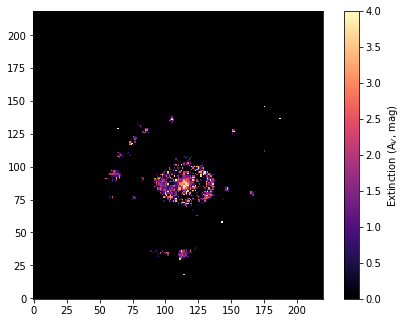

In [49]:
make_balmer_map(ha_image, hb_image, hdr, makeplot=True, writefits=False)

We've just mapped exctinction and (roughly) column density across the entire galaxy. Cool. 

#### Exercise

Try making some other scientifically useful line ratio maps! Can you think of a good proxy for gas electron density, for example? ;) 

### Finally, just for fun: Generate a gif movie from slices in a MUSE data cube

Read in the MUSE cube and print its contents.

In [50]:
image_file = cars_data_directory + 'HE0227-0913.binned.fits'
hdulist = fits.open(image_file)
hdulist.info()

Filename: data/HE0227-0913.binned.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      44   (220, 219, 3681)   float32   
  1  ERROR         1 ImageHDU         9   (220, 219, 3681)   float32   


Read in the image data and header:

In [51]:
data = hdulist[0].data
header = hdulist[0].header
hdulist.close()

I want to make a movie that steps through the velocity structures of the H-alpha + [N II] emission lines. Let's find roughly where that is in the cube. 

In [52]:
ha_wavelength_at_z = 6563*u.AA * (1+z)
ha_wavelength_at_z

<Quantity 6670.9613500000005 Angstrom>

Let's first identify (roughly) which spectral channel in the MUSE cube this wavelength corresponds to. Note that the spectral axis of the MUSE cube is not "automatically" in units of wavelength. One needs to convert the spectral axis to a wavelength array using the dispersion information encoded in the FITS header, following the standard FITS `CRPIX / CRDEL` keywords. 

How do we do this? 

First, let's take a look at the shape of the cube itself:

In [53]:
np.shape(data)

(3681, 219, 220)

There are 3681 spectral elements (channels), and 219x220 spatial elements (e.g. RA, Dec "pixels" across the FOV, if you will). This is smaller than the native MUSE pixel resolution because we've binned up the data to increase S/N. 

In [54]:
number_of_channels = len(data[:,0,0])
number_of_channels

3681

You might not be familiar with how the wavelength axis is encoded in MUSE data (or all FITS images, for that matter). By the FITS standard, we encode the dispersion thusly: 
```
CUNIT3  = 'Angstrom'
CD3_3   = 1.25
CRPIX3  = 1.
CRVAL3  = 4749.70068359375    
```

__This is how you create a wavelength array__:

In [55]:
wavelength = ((np.arange(number_of_channels) + 1.0) - header['CRPIX3']) * header['CD3_3'] + header['CRVAL3']
wavelength

array([ 4749.56738281,  4750.81738281,  4752.06738281, ...,  9347.06738281,
        9348.31738281,  9349.56738281])

That looks better! We now have a wavelength array. Let's find which channel number corresponds to the redshifted wavelength of H$\alpha$ for this source. 

In [56]:
# This quick one liner finds the element in the wavelength array 
# that is closest to the "target" wavelength, then returns that element's 
# index. 

# It finds the deviation between each array element and the target value, 
# takes its absolute value, and then returns the index of 
# the element with the smallest value in the resulting array. 
# This is the number that is closest to the target. 

ha_channel = (np.abs(wavelength - ha_wavelength_at_z.value)).argmin()
ha_channel

1537

So we know that the H$\alpha$ line centroid should be somewhat close to the above channel. It probably won't be exact, because the emission line redshift can sometimes differ a bit from the redshift reported in NED. But it'll be very close. 

Let's plot this channel:


First, though, we'll make a temporary directory to store our movie "frames" in: 

In [57]:
temp_movie_dir = "movie/"

if not os.path.exists(temp_movie_dir):
    os.makedirs(temp_movie_dir)

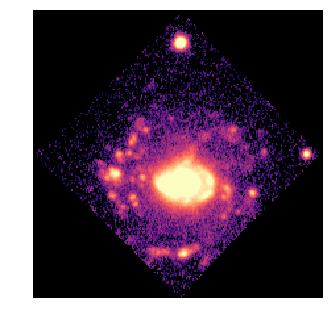

In [59]:
image = data[ha_channel,:,:]

fig = plt.figure()


ax = plt.axes([0,0,1,1])

cmap = cm.magma
cmap.set_bad('black',1)

plt.axis('off')

frame = plt.imshow(image, origin='lower', norm=LogNorm(), vmin=0.001, vmax=0.1, cmap=cmap, interpolation='None')

# fig.savefig(temp_movie_dir + 'testframe.png', dpi=300, bbox_inches=0, pad_inches=0)

We can do a *very* rough continuum subtraction, too. We know, for example, that 200 spectral channels blueward of the H$\alpha$ peak will always land in a line-free region of the continuum. We're only showing one channel at a time, so let's just subtract this smooth continuum-only channel from every frame of our movie, i.e.: 

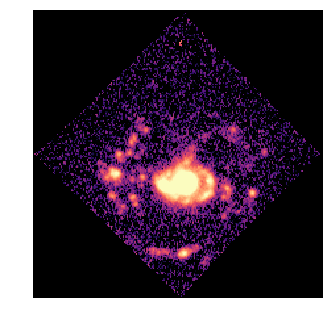

In [60]:
cont_sub_image = data[ha_channel,:,:] - data[ha_channel - 200,:,:]

fig = plt.figure()

cmap = cm.magma
cmap.set_bad('black',1)

plt.axis('off')

fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

frame = plt.imshow(cont_sub_image, origin='lower', norm=LogNorm(), vmin=0.001, vmax=0.1, cmap=cmap, interpolation='None')

# fig.savefig(temp_movie_dir + 'testframe.png', dpi=300, bbox_inches='tight', pad_inches=0)

Not bad for a cheap continuum subtraction, right?! 

#### Now, we can make the movie! 

Hopefully the stuff below is pretty straightforward. Again, let me know if you don't understand something!

In [70]:
### How long do you want each movie? 
channels_to_show = 30 # <-- Change me
####################################

movie_start = ha_channel - channels_to_show
movie_end = ha_channel + channels_to_show


slices_of_interest = np.arange(movie_start, movie_end, 1)
png_files = []

# Clean the temporary movie directory first
for f in glob.glob(temp_movie_dir + "*.png"):
    os.remove(f)

for i, slice in enumerate(slices_of_interest):
    cont_sub_image = data[slice,:,:] - data[ha_channel - 200,:,:]
    fig = plt.figure(figsize=(3,3))
    plt.axis('off')
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    cmap = cm.magma
    cmap.set_bad('black',1)
    frame = plt.imshow(cont_sub_image, origin='lower', norm=LogNorm(), vmin=0.001, vmax=0.1, cmap='magma', interpolation='None')
    fig.savefig('movie/' + '{}'.format(i) + '.png', dpi=100, bbox_inches='tight', pad_inches=0)
    png_files.append('movie/' + '{}'.format(i) + '.png')
    plt.close(fig) # don't spam me with a gajillion figures

In [71]:
gif_name = 'movie.gif'

gif_frames = []

if os.path.isfile(gif_name):
    os.remove(gif_name)

for filename in png_files:
    gif_frames.append(imageio.imread(filename))

imageio.mimsave(gif_name, gif_frames)



In [72]:
import random
__counter__ = random.randint(0,2e9)

from IPython.display import HTML, display
display(HTML('<img src={}>'.format(gif_name)))

The movie should look like this: 

![Learn to make this movie](images/movie.gif)
